# 24 - Classifying All-NBA Players (Part VI - Random Forest)
In the last post, I explored a single decision tree. In this post, I'm going to expand on that single tree to look at the random forest model.

Before we get into random forests, we have to understand the error breakdown of a decision tree. Intrinsically, a tree boasts higher variance compared to some other models. Although a tree is more robust to outliers, it can definitely be overfit and a switch in training data could result in a completely different tree than we got before. Remember, in general, trees are grown _**recursively**_: If two training data sets yield different first tree splits, the trees themselves will be completely different once grown out. It will generally capture the regions of accuracy (bias across consistent training sets and trees should be consistent as well), but the trees will vary quite a bit from one to the next.

Also, before we get into random forests, we need to talk about _**bagging**_ trees. _**Bagging (Bootstrap Aggregating)**_ trees involve using an aggregation method called _**ensemble learning**_, where we build a committee of models and essentially of them vote on the right answer. Here, we're not only building one tree, but we are building up to hundreds. If we build the same tree 200 times... what will change? Well, the kicker with bagging comes from the _**bootstrap**_ part of it. Essentially, instead of using the same training set over and over again, we develop new training sets for every tree by _**sampling from the original training set with replacement**_. This allows us to build slightly new training sets every time and average the models together to reduce this variance.

Finally, random forests go one step further by only taking a subset of predictors on each tree as well. In our exercise, we've only been using two predictors in our models so far... pretty simple... WS and VORP. Within a random forest, we'd build multiple trees and, not only do we take a bootstrapped sample for our training set, we also only choose one of the two predictors to use in any given tree. This aims to further reduce the correlation between trees to bring down the variance of the model even further.

While a random forest makes the decision tree less interpretable (we can't quite make sense of the model as a "tree" anymore), it boasts other very useful features that we'll end up exploring throughout the post. I'll be using the video below to guide me.

[![IMAGE ALT TEXT](http://img.youtube.com/vi/dJclNIN-TPo/0.jpg)](http://www.youtube.com/watch?v=dJclNIN-TPo "Video Title")

Leggo!

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)
%R library(dplyr)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

Again, let's remind ourselves what the data looks like first.

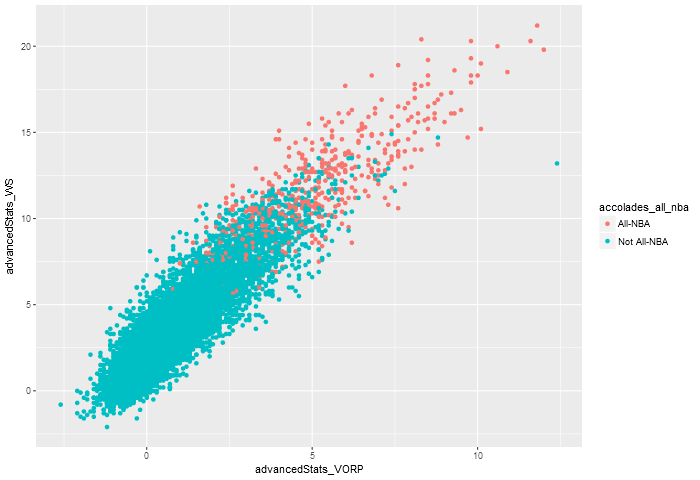

In [3]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

# Plot WS vs VORP scatter with predictions colored in
allNbaPlot = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
)

allNbaPlot

Random forests are relatively user friendly when training the model because there are only 2 parameters that we generally tweak:
- _**ntree**_: Number of trees to grow and aggregate
- _**mtry**_: Number of predictors to choose from our original set of predictors
    - For classification problems, a the default value is set to $\sqrt{p}$

I don't quite know if the 500 trees will be good or bad, but I know we definitely need to tweak _**mtry**_ to be 1 because, well, we only have 2 predictors!

In [21]:
%%R -o randomForestModel
library(randomForest)

# Set seed so we can reproduce results
set.seed(2)

# Build random forest model
randomForestModel = randomForest(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 
    data = playerAggDfAllNbaAllStar,
    mtry = 1
)

In [22]:
print randomForestModel



Call:

 randomForest(formula = accolades_all_nba ~ advancedStats_WS +      advancedStats_VORP, data = playerAggDfAllNbaAllStar, mtry = 1) 

               Type of random forest: classification

                     Number of trees: 500

No. of variables tried at each split: 1



        OOB estimate of  error rate: 2.68%

Confusion matrix:

            All-NBA Not All-NBA class.error

All-NBA         275         227 0.452191235

Not All-NBA     127       12591 0.009985847



Alright, so some interesting and useful output within the random forest model. We've grown 500 trees with 1 variable tried at each split and get get an OOB error of 2.66%. What is OOB? OOB is _**Out of Bag**_, and it is a feature of random forest that mimics cross validation.

At each tree, we're bootstrapping _**with replacement**_. This implies that there are samples that were left out of each training set. As a quick example, if I were to perform bootstrapping _**with replacement**_ on a bag with a red, green, and yellow marble, I might get the following sample sets:
- red, red, green
- green, yellow, yellow
- green, green, green

Because I'm sampling with replacement, there is a high chance that I will pick the same marble twice. When that happens, it implies that there will be observations left out in the set (in the third case, neither red nor yellow were part of the sample set).

What _**out of bag**_ implies, then, are the samples that were not included in the bootstrap sampled set. However, these samples can actually be used to essentially _**cross validate**_ our training set at each tree! In this way, growing a random forest intrinsically gives you cross-validation like functionality and therefore should be able to give us intrinsic information about when we can stop growing trees (for computational efficiency). If we don't need to grow 500 trees, why do it?

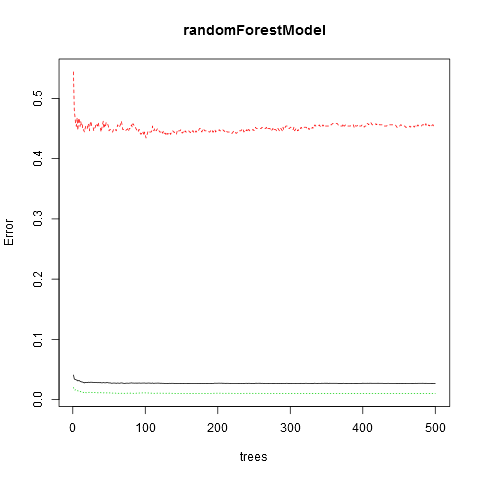

In [23]:
%%R
# Plot random forest model
plot(randomForestModel)

In the plot above, the black solid line indicates the OOB error and the red and green lines represent the class errors. We immediately see that 500 is way too many trees, let's 

In [68]:
%%R -o randomForestModelMinTrees

# Extract the column of ntree and OOB error rates
errRate = as.data.frame(randomForestModel['err.rate'])['err.rate.OOB']

# Find the number of trees which yield the minimum OOB error
minTree = min(which(errRate['err.rate.OOB'] == min(errRate['err.rate.OOB'])))

# Retrain tree with this number of trees
randomForestModelMinTrees = randomForest(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 
    data = playerAggDfAllNbaAllStar,
    ntree = minTree,
    mtry = 1
)

In [69]:
print randomForestModelMinTrees



Call:

 randomForest(formula = accolades_all_nba ~ advancedStats_WS +      advancedStats_VORP, data = playerAggDfAllNbaAllStar, ntree = minTree,      mtry = 1) 

               Type of random forest: classification

                     Number of trees: 141

No. of variables tried at each split: 1



        OOB estimate of  error rate: 2.66%

Confusion matrix:

            All-NBA Not All-NBA class.error

All-NBA         279         223   0.4442231

Not All-NBA     129       12589   0.0101431



Barely better, but the OOB error did drop a bit! We know a bit more information about the number of trees, but we don't have too much insight into the trees themselves. One quick measure we can check is the histogram of how many nodes each tree has:

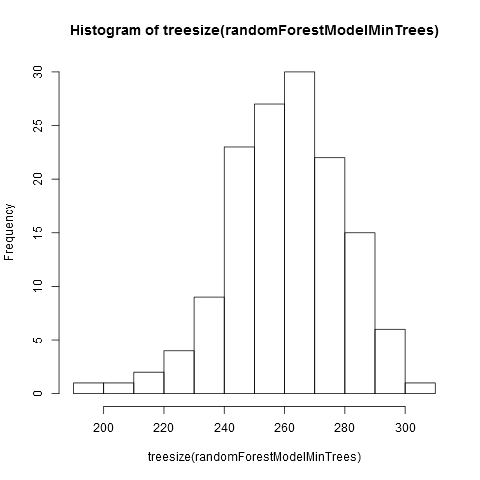

In [70]:
%%R
# Build hist of random forest tree nodes
hist(treesize(randomForestModelMinTrees))

We have most trees lingering around 260 nodes... these trees are quite deep! But that's not all the goodies we get from a random forest... we can also get a bit of intrinsic insight into feature selection! 

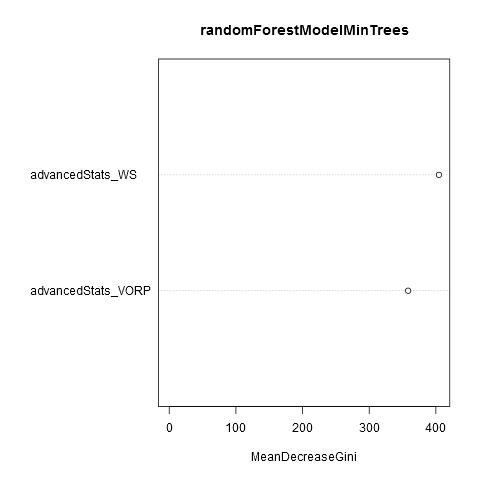

In [75]:
%%R
# Build variable importance plot
varImpPlot(randomForestModelMinTrees)

The plot above shows _**how much worse a model does when the feature is left out of the model**_. Perhaps counter-intuitive to the last post where we modeled one decision tree, the random forest is actually saying that both variables are of similar importance. We have to remember here, however, that our random forest is growing very deep trees (mean of 260 nodes) where our single decision tree yielded a shallow tree (<10 nodes). We saw that when we actually grew our single decision tree out to past 10 nodes, VORP was definitely involved in the model. Anyways, we see a similar story with WS being the more important feature between the two.

Another feature of the random forest is the partial dependency plot to understand the dependency of a certain class on a certain feature.

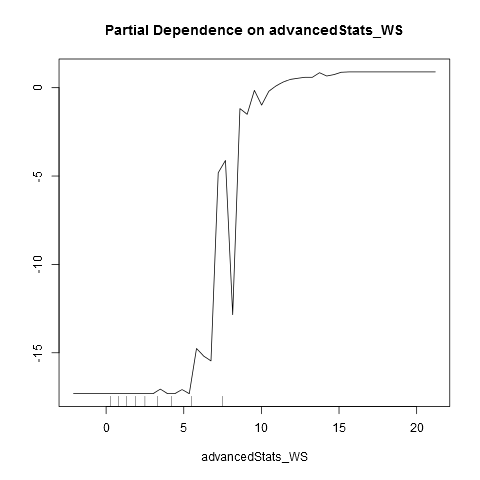

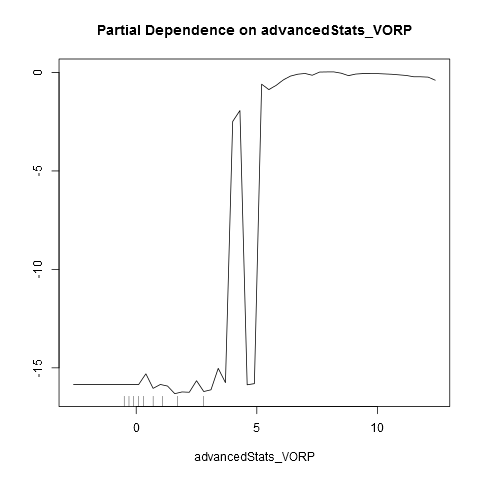

In [77]:
%%R
# Build partial dependence plots of each class to each feature
partialPlot(randomForestModelMinTrees, playerAggDfAllNbaAllStar, advancedStats_WS, 'All-NBA')
partialPlot(randomForestModelMinTrees, playerAggDfAllNbaAllStar, advancedStats_VORP, 'All-NBA')

Here, we plotted the dependency of classifying all-NBA players on the two features in our model. Note that since we have only 2 classes, the non all-NBA dependency plots would simply be the inverse of these two plots.

If we take a look at WS first, between 7 and 10 are the problem areas for classifying all-NBA players. With VORP, between 4 and 5 are the problem areas. This agrees with some of the models we had built in the previous posts, especially in our single decision tree where a WS between 8 and 10 provided less confidence.

The random forest is really the gift that keeps on giving... we can also build _**proximity**_ plots! When our random forest model is generating all the trees, it also builds a proximity matrix at the same time. A proximity matrix is basically an $N\times N$ matrix that measures the "similarity" between nodes. We saw the proximity matrix concept when we reviewed isomaps. Random forest builds this matrix by keeping track of all observations in the same terminal node. Everytime two observations end up in the same terminal node within a tree, their proximity "counter" is increased by one. Through all the trees, we are able to tally up which observations end up in which nodes. I suspect that for our purposes, it won't make much of a difference because our proximity plot ends up being a 2D scale plot. Since our original data only has 2 dimensions / features anyways, it will probably look the same?

Alright... last thing I'm going to try... as always, we gotta build the ROC curve.

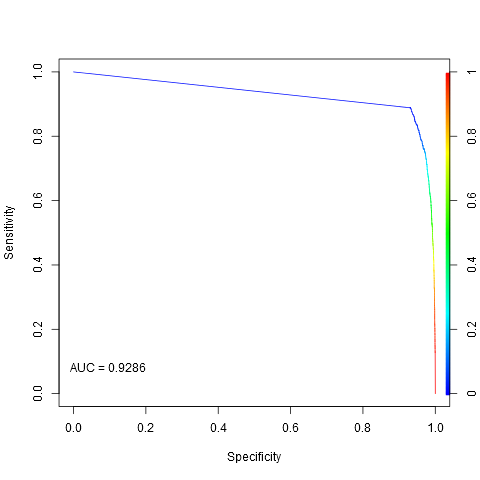

In [87]:
%%R -o randomForestModelMinTreesPred
library(ROCR)

# Use the tree library to predict probabilities
randomForestModelMinTreesPred = predict(randomForestModelMinTrees, type = 'prob')

# Use the ROCR library to build the ROC curve
randomForestPredObj = prediction(as.data.frame(randomForestModelMinTreesPred[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
randomForestRocEval = performance(randomForestPredObj, 'sens', 'spec')
plot(randomForestRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(randomForestPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [88]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = randomForestRocEval@alpha.values[[1]], sens = randomForestRocEval@x.values[[1]], spec = randomForestRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
595,0.015873,0.930414,0.888446,1.818860
589,0.017544,0.932458,0.886454,1.818912
594,0.016129,0.930492,0.888446,1.818938
593,0.016393,0.930649,0.888446,1.819096
592,0.016667,0.931200,0.888446,1.819646
591,0.016949,0.931514,0.888446,1.819961


Alrighty... Looks like the random forest actually performs poorly than pretty much all our other models. I wasn't quite expecting this, and I don't throw out the idea that I did something wrong along the way or that I'm misunderstanding something, but both AUC and the sensitivity / specificity predictive power is lower than we've seen before. at 93% / 89%, we can't be too unhappy with the predictive power, but we've obviously seen better.

What definitely surprises me is that the random forest performs _**worse**_ than a single tree with 5 frickin terminal nodes. 5 FRICKIN TERMINAL NODES!!!! I'm starting to see some of the trade-offs though. If I'm going into a meeting with a business executive, am I really going to sit down and explain all the bells and whistles of the random forest, let alone the random forest itself? Or am I going to sit down and give a super simple tree diagram and say "hey this predicts @ 95% / 90% accuracy".

At the same time, though, if I were sitting down with a more technical analyst, they might want to see all the bells and whistles because plots like the variable importance, partial dependence, and proximity plots allow us to gain more insight and perspective into how the data is partitioned.

Regardless, another model that does a fine job of predicting all-NBA players!